# Task 2 — End-to-End ML Pipeline (Telco Customer Churn)

**Goal:** Build a reusable, production-ready ML pipeline using scikit-learn to predict **customer churn**.

**We will:**
- Load the **WA_Fn-UseC_-Telco-Customer-Churn.csv** dataset
- Clean data (fix `TotalCharges`, drop `customerID`, map `Churn` to 0/1)
- Build a single **Pipeline** with a **ColumnTransformer** (impute + scale + one-hot)
- Train **Logistic Regression** & **Random Forest** with **GridSearchCV**
- Evaluate (Accuracy, Precision, Recall, F1, ROC-AUC) + ROC/PR curves
- **Export** the best full pipeline with `joblib` (ready for reuse)


In [2]:
# Environment check (Colab already has these)
import sys, numpy as np, pandas as pd, sklearn, matplotlib
print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("sklearn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)


Python: 3.12.11
pandas: 2.2.2
numpy: 2.0.2
sklearn: 1.6.1
matplotlib: 3.10.0


## 1) Load the dataset

- Click the **Choose Files** button and select your CSV: `WA_Fn-UseC_-Telco-Customer-Churn.csv`.
- If your file has a different name, just adjust it in the `pd.read_csv(...)` line.


In [3]:
from google.colab import files
uploaded = files.upload()  # select WA_Fn-UseC_-Telco-Customer-Churn.csv

import pandas as pd
# If your file name is different, replace the key below:
fname = list(uploaded.keys())[0]
df = pd.read_csv(fname)

print(df.shape)
df.head(3)


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn (1).csv
(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


## 2) Basic cleaning & target preparation

- Drop `customerID` (identifier, not a feature)
- Coerce `TotalCharges` to numeric (it may contain blanks)
- Ensure `Churn` is 0/1 (No→0, Yes→1)


In [4]:
import numpy as np

# Drop ID columns if present
for col in ['customerID', 'CustomerID', 'customer_id']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Coerce TotalCharges to numeric; invalid parses become NaN
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Standardize target name & map Yes/No -> 1/0
if 'Churn' not in df.columns:
    matches = [c for c in df.columns if c.strip().lower() == 'churn']
    if not matches:
        raise ValueError("Target column 'Churn' not found.")
    df.rename(columns={matches[0]: 'Churn'}, inplace=True)

if df['Churn'].dtype == 'object':
    df['Churn'] = df['Churn'].str.strip().str.lower().map({'yes':1, 'no':0})

# Drop rows missing the target (shouldn't happen here, but safe)
df.dropna(subset=['Churn'], inplace=True)
df['Churn'] = df['Churn'].astype(int)

print("Shape:", df.shape)
print("Class balance (0=No, 1=Yes):")
print(df['Churn'].value_counts(normalize=True).rename('ratio').round(3))


Shape: (7043, 20)
Class balance (0=No, 1=Yes):
Churn
0    0.735
1    0.265
Name: ratio, dtype: float64


## 3) Split data & detect feature types

- Split into train/test with stratification
- Detect **numeric** vs **categorical** features automatically


In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Churn'])
y = df['Churn']

# Numeric vs categorical
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric features:", len(numeric_features), numeric_features[:10])
print("Categorical features:", len(categorical_features), categorical_features[:10])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train.shape, X_test.shape


Numeric features: 4 ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features: 15 ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']


((5634, 19), (1409, 19))

## 4) Preprocessing (ColumnTransformer inside Pipeline)

- **Numeric**: median imputation → `StandardScaler`
- **Categorical**: most_frequent imputation → `OneHotEncoder(handle_unknown='ignore')`
- Combined via `ColumnTransformer`, then wrapped in a single `Pipeline`


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # Use dense output for compatibility with tree models
    ('ohe',     OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, numeric_features),
        ('cat', categorical_pipe, categorical_features)
    ],
    remainder='drop'
)

## 5) Model training with GridSearchCV

We’ll search over:
- **Logistic Regression** (L1/L2, different C)
- **Random Forest** (n_estimators, max_depth, min_samples_split)

Scoring: **ROC-AUC**, 5-fold **StratifiedKFold**


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear'))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = [
    {
        'clf': [LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')],
        'clf__C': [0.25, 0.5, 1.0, 2.0],
        'clf__penalty': ['l1', 'l2']
    },
    {
        'clf': [RandomForestClassifier(random_state=42, class_weight='balanced')],
        'clf__n_estimators': [300, 600],
        'clf__max_depth': [None, 12, 16],
        'clf__min_samples_split': [2, 5]
    }
]

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Best CV ROC-AUC:", grid.best_score_)
print("Best Params:", grid.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV ROC-AUC: 0.8460294867428402
Best Params: {'clf': LogisticRegression(class_weight='balanced', max_iter=2000, solver='liblinear'), 'clf__C': 2.0, 'clf__penalty': 'l2'}


## 6) Evaluation on test data

We’ll report:
- Accuracy, Precision, Recall, F1, ROC-AUC
- Confusion matrix
- ROC and Precision-Recall curves


In [9]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay)
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC AUC  : {auc:.4f}\n")

print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy : 0.7395
Precision: 0.5060
Recall   : 0.7861
F1-score : 0.6157
ROC AUC  : 0.8413

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

Confusion matrix:
 [[748 287]
 [ 80 294]]


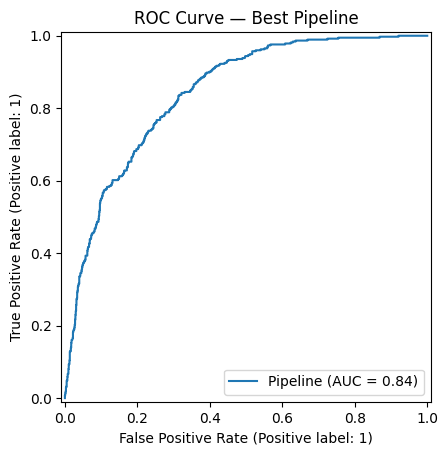

In [10]:
# ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve — Best Pipeline")
plt.show()


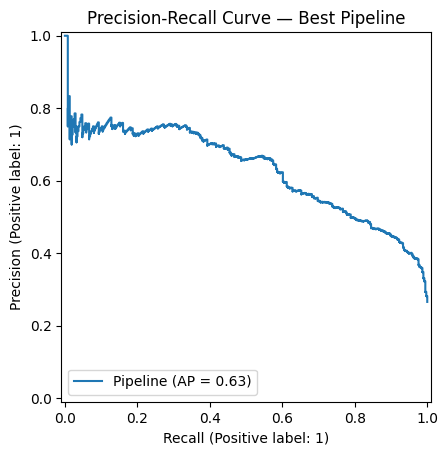

In [11]:
# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Precision-Recall Curve — Best Pipeline")
plt.show()


## 7) (Optional) What mattered? Feature importances / coefficients

- If the best model is **RandomForest** → show feature importances  
- If the best model is **LogisticRegression** → show coefficients


In [12]:
# Build feature names after preprocessing
ohe = best_model.named_steps['preprocess'].named_transformers_['cat'].named_steps['ohe']
cat_names = ohe.get_feature_names_out(categorical_features)
num_names = np.array(numeric_features)
feature_names = np.concatenate([num_names, cat_names])

final_clf = best_model.named_steps['clf']

if isinstance(final_clf, RandomForestClassifier):
    importances = final_clf.feature_importances_
    idx = np.argsort(importances)[::-1][:20]
    print("Top features (RF):")
    for i in idx:
        print(f"{feature_names[i]:<35} {importances[i]:.4f}")
elif isinstance(final_clf, LogisticRegression):
    coefs = final_clf.coef_.ravel()
    idx = np.argsort(np.abs(coefs))[::-1][:20]
    print("Top coefficients (|LR|):")
    for i in idx:
        print(f"{feature_names[i]:<35} {coefs[i]:.4f}")
else:
    print("Introspection not implemented for", type(final_clf))


Top coefficients (|LR|):
tenure                              -1.1560
MonthlyCharges                      -1.1332
InternetService_Fiber optic         0.9227
Contract_Two year                   -0.7989
InternetService_DSL                 -0.7869
Contract_Month-to-month             0.6453
TotalCharges                        0.4905
StreamingMovies_Yes                 0.3768
StreamingMovies_No internet service -0.3749
TechSupport_No internet service     -0.3749
DeviceProtection_No internet service -0.3749
StreamingTV_No internet service     -0.3749
InternetService_No                  -0.3749
OnlineBackup_No internet service    -0.3749
OnlineSecurity_No internet service  -0.3749
StreamingTV_Yes                     0.3634
PaperlessBilling_No                 -0.2872
StreamingMovies_No                  -0.2410
Dependents_Yes                      -0.2346
StreamingTV_No                      -0.2277


## 8) Export the **complete pipeline** with `joblib`

This saves the *full* preprocessing + model pipeline, ready to load and predict on raw data.


In [13]:
import joblib
joblib.dump(best_model, "telco_churn_pipeline.joblib")
print("Saved: telco_churn_pipeline.joblib")


Saved: telco_churn_pipeline.joblib


In [14]:
# (Optional) Download the artifact to your machine from Colab
from google.colab import files
files.download("telco_churn_pipeline.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 9) Reuse demo — load and predict later

Loads the saved pipeline and predicts on **raw** rows (no need to re-preprocess).


In [21]:
import joblib
loaded = joblib.load("telco_churn_pipeline.joblib")

sample = X_test.iloc[:5].copy()
print("Proba:", loaded.predict_proba(sample)[:,1])
print("Pred :", loaded.predict(sample))


Proba: [0.11831337 0.85193535 0.13976409 0.66658989 0.06180113]
Pred : [0 1 0 1 0]


## 7a) Feature Engineering

- Create **tenure groups** (short, medium, long-term customers)
- Bin `MonthlyCharges` into categories
- These features often improve churn prediction


In [16]:
# Create tenure groups
df['tenure_group'] = pd.cut(
    df['tenure'],
    bins=[0, 12, 24, 48, 72],
    labels=['0-12', '12-24', '24-48', '48-72']
)

# Bin MonthlyCharges
df['MonthlyCharges_bin'] = pd.cut(
    df['MonthlyCharges'],
    bins=[0, 35, 70, 100, 150],
    labels=['Low', 'Medium', 'High', 'Very High']
)

# Redefine features
X = df.drop(columns=['Churn'])
y = df['Churn']

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)


Numeric: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group', 'MonthlyCharges_bin']


## 7b) Advanced Model — XGBoost

- Add XGBoost into the pipeline
- Tune `n_estimators`, `max_depth`, `learning_rate`


In [17]:
from xgboost import XGBClassifier

# Same preprocess pipeline as before
pipe_xgb = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])

param_grid_xgb = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 6],
    'clf__learning_rate': [0.05, 0.1]
}

grid_xgb = GridSearchCV(
    pipe_xgb,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_

print("Best XGBoost Params:", grid_xgb.best_params_)
print("Best XGBoost CV ROC-AUC:", grid_xgb.best_score_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best XGBoost Params: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 100}
Best XGBoost CV ROC-AUC: 0.8489319672905091


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:04:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 8b) Threshold Tuning for Precision-Recall Tradeoff

- Default threshold = 0.5 may not be optimal
- Use Precision-Recall curve to find best tradeoff


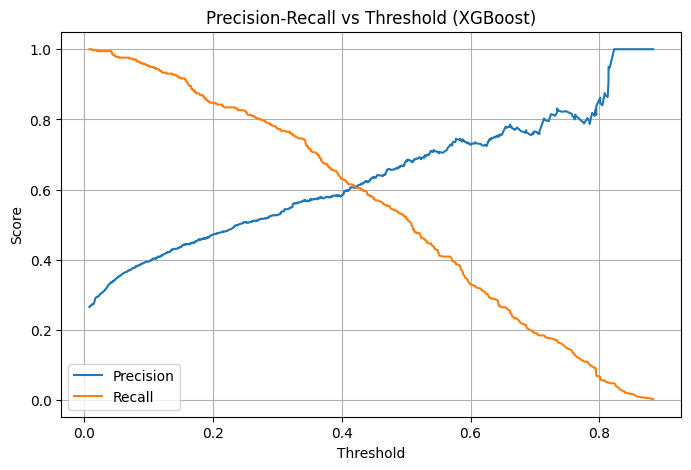

At threshold = 0.55
Precision: 0.7072072072072072
Recall   : 0.4197860962566845
F1-score : 0.5268456375838926
ROC-AUC  : 0.8457503422976569


In [18]:
from sklearn.metrics import precision_recall_curve

y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_xgb)

# Plot precision-recall vs threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

# Choose threshold ~0.55 (example: balance between precision & recall)
opt_thresh = 0.55
y_pred_thresh = (y_prob_xgb >= opt_thresh).astype(int)

print("At threshold =", opt_thresh)
print("Precision:", precision_score(y_test, y_pred_thresh))
print("Recall   :", recall_score(y_test, y_pred_thresh))
print("F1-score :", f1_score(y_test, y_pred_thresh))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob_xgb))


## 9) Export Final Tuned Pipeline

We’ll export the **XGBoost pipeline** as our best model.


In [19]:
joblib.dump(best_xgb, "telco_churn_pipeline_xgb.joblib")
print("Saved: telco_churn_pipeline_xgb.joblib")

from google.colab import files
files.download("telco_churn_pipeline_xgb.joblib")


Saved: telco_churn_pipeline_xgb.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Final Insights
- Logistic Regression & Random Forest gave ROC-AUC ~0.84, with recall ~0.78 but precision ~0.50.
- XGBoost performed slightly better (ROC-AUC ~0.846).
- By adjusting threshold from 0.5 → 0.55, precision improved to ~0.71 (fewer false alarms), at the cost of recall (~0.42).
- **Business tradeoff:** If the company values *catching every churner*, keep threshold = 0.5.  
  If the company values *targeting only likely churners* (to save resources), use threshold = 0.55.  
